# 🤖 AI Agents Demo: Autonomous Data Cleaning & EDA

Welcome! In this notebook we'll see AI agents in action — not just chatting, but **doing real work**.

We'll go step by step:
1. What's an LLM? (quick recap)
2. What makes an agent different from a chatbot?
3. Explore each piece of our data agent
4. Run the full agent pipeline on a real CSV

No prior AI experience needed. If you can read Python, you're good.

---
## Part 1: Setup

First, let's make sure everything is installed. Run the cell below once.

In [1]:
# If running in Colab or a fresh environment, uncomment and run:
# !pip install langchain langgraph langchain-openai langchain-anthropic langchain-groq langchain-aws pandas matplotlib seaborn chardet
# git clone https://github.com/dcolinmorgan/EDAcleanr
# cd EDAcleanr
# uv pip install -e . --reinstall-package data-cleaning-eda-agent

#change LLMs and providers in `src/tools/llm_config.py`

# uv run eda-agent '/Users/apple/Downloads/spreadsheet.csv' --provider bedrock --region eu-north-1


In [2]:
import os
import pandas as pd
import json

# Set your API key here (pick ONE provider)
# Option A: OpenAI
# os.environ["OPENAI_API_KEY"] = "sk-..."

# Option B: Anthropic
# os.environ["ANTHROPIC_API_KEY"] = "sk-ant-..."

# Option C: Groq (free tier available)
# os.environ["GROQ_API_KEY"] = "gsk_..."

# Option D: AWS Bedrock — uses your AWS credentials, no key needed here

print("Setup complete")

Setup complete


---
## Part 2: Quick LLM Recap

An LLM (Large Language Model) is an AI trained on massive amounts of text. 
It predicts the next word — but does it so well that it can write code, answer questions, and reason about problems.

Let's see one in action:

In [3]:
# !aws sso login

In [4]:
from src.llm_config import get_llm

# Change provider/model to match your API key
# Options: "openai", "anthropic", "groq", "bedrock"
PROVIDER = "bedrock"

# For Bedrock, also pass region_name:
# llm = get_llm(provider="bedrock", region_name="eu-north-1")
llm = get_llm(provider=PROVIDER)

print(f"Using provider: {PROVIDER}")

/Users/apple/Developer/olink/EDAcleanr/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


Using provider: bedrock


In [5]:
# A simple LLM call — just a chatbot, not an agent yet
response = llm.invoke("What are the 3 most common problems in messy CSV files? Be brief.")
print(response.content)

1. **Inconsistent Delimiters**  
2. **Missing or Extra Columns**  
3. **Improper Quoting or Escaping**


That's a **chatbot**: you ask, it answers. One shot.

An **agent** goes further — it gets a goal, thinks about what to do, uses tools, checks results, and loops until done.

```
Agent = LLM + Tools + Memory + Reasoning Loop
```

Let's build up to that.

---
## Part 3: Load a Messy CSV

Our agent's first job: load a CSV file. This sounds simple, but real-world CSVs have encoding issues, weird delimiters, and other surprises.

Our loader handles all of that automatically.

In [6]:
from src.csv_loader import load_csv
# https://www.kaggle.com/datasets/joannanplkrk/dirty-data-to-clean-whats-wrong-with-this-dataset
# Point this to your CSV file
# CSV_PATH = "../../../Downloads/archive/animal_data_dirty1.csv"  # <-- change this!

CSV_PATH = "../../../Downloads/proteinatlas.tsv"  # <-- change this!

result = load_csv(CSV_PATH)

if result["error"]:
    print(f"Error: {result['error']}")
else:
    df = result["df"]
    print(f"Loaded successfully!")
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded successfully!
Shape: 20162 rows x 107 columns
Columns: ['Gene', 'Gene synonym', 'Ensembl', 'Gene description', 'Uniprot', 'Chromosome', 'Position', 'Protein class', 'Biological process', 'Molecular function', 'Disease involvement', 'Evidence', 'HPA evidence', 'UniProt evidence', 'NeXtProt evidence', 'RNA tissue specificity', 'RNA tissue distribution', 'RNA tissue specificity score', 'RNA tissue specific nTPM', 'RNA single cell type specificity', 'RNA single cell type distribution', 'RNA single cell type specificity score', 'RNA single cell type specific nTPM', 'RNA single nuclei brain specificity', 'RNA single nuclei brain distribution', 'RNA single nuclei brain specificity score', 'RNA single nuclei brain specific nTPM', 'RNA cancer specificity', 'RNA cancer distribution', 'RNA cancer specificity score', 'RNA cancer specific FPKM', 'RNA brain regional specificity', 'RNA brain regional distribution', 'RNA brain regional specificity score', 'RNA brain regional specific nTPM', 'RN

---
## Part 4: Inspect — What's Wrong With This Data?

Before cleaning, we need to know what's broken. Our inspection tools check for:
- Missing values (per column)
- Duplicate rows
- Outliers (using the IQR method)
- Mixed types in columns (numbers and text mixed together)
- High cardinality (too many unique values in a category)
- Zero variance columns (same value everywhere — useless)

In [7]:
from src.tools.inspection import detect_issues, get_df_info

# Profile the data
profile = get_df_info(df)
print(profile[:1000])  # first 1000 chars to keep it readable
print("\n... (truncated)")

Shape: 20162 rows x 107 columns

Column Data Types:
  Gene: str
  Gene synonym: str
  Ensembl: str
  Gene description: str
  Uniprot: str
  Chromosome: str
  Position: str
  Protein class: str
  Biological process: str
  Molecular function: str
  Disease involvement: str
  Evidence: str
  HPA evidence: str
  UniProt evidence: str
  NeXtProt evidence: str
  RNA tissue specificity: str
  RNA tissue distribution: str
  RNA tissue specificity score: float64
  RNA tissue specific nTPM: str
  RNA single cell type specificity: str
  RNA single cell type distribution: str
  RNA single cell type specificity score: float64
  RNA single cell type specific nTPM: str
  RNA single nuclei brain specificity: str
  RNA single nuclei brain distribution: str
  RNA single nuclei brain specificity score: float64
  RNA single nuclei brain specific nTPM: str
  RNA cancer specificity: str
  RNA cancer distribution: str
  RNA cancer specificity score: float64
  RNA cancer specific FPKM: str
  RNA brain regiona

In [8]:
# Detect all issues
issues = detect_issues(df)

print("=== Issue Report ===")
print("\nMissing values (% per column):")
for col, pct in issues["missing_pct"].items():
    if pct > 0:
        print(f"  {col}: {pct:.1f}%")

print(f"\nDuplicate rows: {issues['duplicate_count']}")

print("\nOutliers (IQR method):")
for col, indices in issues["outliers"].items():
    print(f"  {col}: {len(indices)} outlier(s)")

if issues["inconsistent_types"]:
    print(f"\nMixed types: {issues['inconsistent_types']}")

if issues["zero_variance"]:
    print(f"\nZero variance: {issues['zero_variance']}")

if issues["high_cardinality"]:
    print(f"\nHigh cardinality: {issues['high_cardinality']}")

=== Issue Report ===

Missing values (% per column):
  Gene synonym: 15.8%
  Gene description: 0.1%
  Uniprot: 4.3%
  Biological process: 46.2%
  Molecular function: 45.3%
  Disease involvement: 70.3%
  UniProt evidence: 4.5%
  NeXtProt evidence: 4.8%
  RNA tissue specificity score: 76.5%
  RNA tissue specific nTPM: 45.8%
  RNA single cell type specificity: 0.4%
  RNA single cell type distribution: 0.4%
  RNA single cell type specificity score: 76.0%
  RNA single cell type specific nTPM: 22.0%
  RNA single nuclei brain specificity: 2.9%
  RNA single nuclei brain distribution: 2.9%
  RNA single nuclei brain specificity score: 88.1%
  RNA single nuclei brain specific nTPM: 65.9%
  RNA cancer specificity: 0.9%
  RNA cancer distribution: 0.9%
  RNA cancer specificity score: 89.7%
  RNA cancer specific FPKM: 75.3%
  RNA brain regional specificity score: 97.0%
  RNA brain regional specific nTPM: 94.7%
  RNA blood cell specificity score: 88.8%
  RNA blood cell specific nTPM: 78.2%
  RNA blood

---
## Part 5: Clean — Fix the Problems

Now we use our cleaning tools. In the full agent, the LLM decides which tools to call and in what order. 
Here we'll try them manually so you can see what each one does.

In [9]:
from src.tools.cleaning import (
    drop_duplicates,
    fill_missing,
    normalize_columns,
    strip_string_values,
    drop_useless_columns,
    remove_outliers,
)

# Start with a copy
cleaned = df.copy()
print(f"Starting shape: {cleaned.shape}")

Starting shape: (20162, 107)


In [10]:
# Step 1: Normalize column names (lowercase, strip whitespace)
cleaned, log = normalize_columns(cleaned)
print(log.description)

Normalized 107 column name(s): 'Gene' -> 'gene', 'Gene synonym' -> 'gene synonym', 'Ensembl' -> 'ensembl', 'Gene description' -> 'gene description', 'Uniprot' -> 'uniprot', 'Chromosome' -> 'chromosome', 'Position' -> 'position', 'Protein class' -> 'protein class', 'Biological process' -> 'biological process', 'Molecular function' -> 'molecular function', 'Disease involvement' -> 'disease involvement', 'Evidence' -> 'evidence', 'HPA evidence' -> 'hpa evidence', 'UniProt evidence' -> 'uniprot evidence', 'NeXtProt evidence' -> 'nextprot evidence', 'RNA tissue specificity' -> 'rna tissue specificity', 'RNA tissue distribution' -> 'rna tissue distribution', 'RNA tissue specificity score' -> 'rna tissue specificity score', 'RNA tissue specific nTPM' -> 'rna tissue specific ntpm', 'RNA single cell type specificity' -> 'rna single cell type specificity', 'RNA single cell type distribution' -> 'rna single cell type distribution', 'RNA single cell type specificity score' -> 'rna single cell type

In [11]:
# Step 2: Strip whitespace from string values
cleaned, log = strip_string_values(cleaned)
print(log.description)

Stripped whitespace from 94 string column(s).


In [12]:
# Step 3: Remove duplicate rows
cleaned, log = drop_duplicates(cleaned)
print(log.description)
print(f"Shape after dedup: {cleaned.shape}")

Removed 0 duplicate rows.
Shape after dedup: (20162, 107)


In [13]:
# Step 4: Drop useless columns (>90% missing or zero variance)
cleaned, log = drop_useless_columns(cleaned)
print(log.description)
print(f"Shape after dropping useless columns: {cleaned.shape}")

Dropped 10 useless column(s): rna brain regional specificity score, rna brain regional specific ntpm, rna mouse brain regional specificity score, rna mouse brain regional specific ntpm, rna pig brain regional specificity score, rna pig brain regional specific ntpm, reliability (mouse brain), ccd protein, ccd transcript, blood concentration - conc. blood im [pg/l]
Shape after dropping useless columns: (20162, 97)


In [14]:
# Step 5: Fill missing values in numeric columns with median
import numpy as np

numeric_cols = cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if cleaned[col].isna().sum() > 0:
        cleaned, log = fill_missing(cleaned, col, "median")
        print(log.description)

print(f"\nRemaining missing values: {cleaned.isna().sum().sum()}")

Filled missing values in 'rna tissue specificity score' using median strategy.
Filled missing values in 'rna single cell type specificity score' using median strategy.
Filled missing values in 'rna single nuclei brain specificity score' using median strategy.
Filled missing values in 'rna cancer specificity score' using median strategy.
Filled missing values in 'rna blood cell specificity score' using median strategy.
Filled missing values in 'rna blood lineage specificity score' using median strategy.
Filled missing values in 'rna cell line specificity score' using median strategy.
Filled missing values in 'blood concentration - conc. blood ms [pg/l]' using median strategy.
Filled missing values in 'interactions' using median strategy.

Remaining missing values: 437013


Each tool returns the cleaned DataFrame plus a log entry describing what it did. 
The agent collects all these logs for the final report.

---
## Part 6: EDA — Explore the Clean Data

Now that the data is cleaner, let's analyze it.

In [15]:
from src.tools.eda import describe_numeric, describe_categorical, compute_correlation, generate_plots

# Numeric statistics
print("=== Numeric Statistics ===")
print(describe_numeric(cleaned))

=== Numeric Statistics ===
       rna tissue specificity score  rna single cell type specificity score  rna single nuclei brain specificity score  rna cancer specificity score  rna blood cell specificity score  rna blood lineage specificity score  rna cell line specificity score  blood concentration - conc. blood ms [pg/l]  interactions
count                  20162.000000                            20162.000000                               20162.000000                  20162.000000                      20162.000000                         20162.000000                     20162.000000                                 2.016200e+04  20162.000000
mean                      28.921635                                9.526684                                   7.120623                     10.566412                         10.460619                            15.704246                         8.649043                                 4.047554e+08     26.683216
std                      269.870549  

In [16]:
# Categorical statistics (top 10 values per column)
print("=== Categorical Statistics ===")
print(describe_categorical(cleaned))

=== Categorical Statistics ===
Column: gene
gene
MKKS       3
MATR3      2
PRODH      2
HERC3      2
TMSB15B    2
POLR2J3    2
NPIPA9     2
PINX1      2
NOX5       2
TBCE       2

Column: gene synonym
gene synonym
CD1                                     3
AMY1                                    3
IGLC                                    3
PRKAR2                                  2
SBBI31                                  2
SAS                                     2
HSPOX2, PIG6, PRODH1, PRODH2, TP53I6    2
CLP                                     2
CAV                                     2
NAG                                     2

Column: ensembl
ensembl
ENSG00000000003    1
ENSG00000000005    1
ENSG00000000419    1
ENSG00000000457    1
ENSG00000000460    1
ENSG00000000938    1
ENSG00000000971    1
ENSG00000001036    1
ENSG00000001084    1
ENSG00000001167    1

Column: gene description
gene description
Novel protein                                                   265
Novel transcript    

In [17]:
# Correlation matrix
print("=== Correlation Matrix ===")
print(compute_correlation(cleaned))

=== Correlation Matrix ===
                                             rna tissue specificity score  rna single cell type specificity score  rna single nuclei brain specificity score  rna cancer specificity score  rna blood cell specificity score  rna blood lineage specificity score  rna cell line specificity score  blood concentration - conc. blood ms [pg/l]  interactions
rna tissue specificity score                                     1.000000                                0.046919                                  -0.005159                      0.288791                         -0.004416                            -0.004043                         0.011189                                     0.042451     -0.021600
rna single cell type specificity score                           0.046919                                1.000000                                  -0.000874                      0.149792                          0.116752                             0.076570                

In [18]:
cleaned

,gene,gene synonym,ensembl,gene description,uniprot,chromosome,position,protein class,biological process,molecular function,...,cancer prognostics - pancreatic adenocarcinoma (tcga),cancer prognostics - pancreatic adenocarcinoma (validation),cancer prognostics - prostate adenocarcinoma (tcga),cancer prognostics - rectum adenocarcinoma (tcga),cancer prognostics - rectum adenocarcinoma (validation),cancer prognostics - skin cuteneous melanoma (tcga),cancer prognostics - stomach adenocarcinoma (tcga),cancer prognostics - testicular germ cell tumor (tcga),cancer prognostics - thyroid carcinoma (tcga),cancer prognostics - uterine corpus endometrial carcinoma (tcga)
0,TSPAN6,"T245, TM4SF6, TSPAN-6",ENSG00000000003,Tetraspanin 6,O43657,X,100627108-100639991,Predicted membrane proteins,NaN,NaN,...,unprognostic (7.49e-5),unprognostic (1.11e-1),unprognostic (3.30e-2),unprognostic (3.36e-3),unprognostic (4.23e-3),unprognostic (1.89e-2),unprognostic (7.95e-2),unprognostic (2.01e-1),unprognostic (4.60e-2),unprognostic (1.59e-1)
1,TNMD,"BRICD4, ChM1L, myodulin, TEM, tendin",ENSG00000000005,Tenomodulin,Q9H2S6,X,100584936-100599885,Predicted membrane proteins,NaN,NaN,...,NaN,NaN,NaN,unprognostic (2.21e-3),NaN,NaN,NaN,unprognostic (1.55e-1),NaN,NaN
2,DPM1,"CDGIE, MPDS",ENSG00000000419,Dolichyl-phosphate mannosyltransferase subunit...,O60762,20,50934867-50959140,"Disease related genes, Enzymes, Human disease ...",NaN,"Glycosyltransferase, Transferase",...,unprognostic (1.64e-3),unprognostic (1.57e-1),unprognostic (5.86e-2),unprognostic (3.10e-3),unprognostic (7.21e-3),unprognostic (6.73e-2),unprognostic (4.37e-1),unprognostic (1.73e-1),unprognostic (2.03e-3),unprognostic (7.59e-2)
3,SCYL3,"PACE-1, PACE1",ENSG00000000457,SCY1 like pseudokinase 3,Q8IZE3,1,169849631-169894267,"Enzymes, Predicted intracellular proteins",NaN,NaN,...,unprognostic (1.31e-1),unprognostic (2.85e-2),unprognostic (3.03e-1),unprognostic (2.05e-1),unprognostic (1.12e-1),unprognostic (2.20e-1),unprognostic (1.57e-1),unprognostic (1.70e-1),unprognostic (7.81e-2),unprognostic (1.02e-1)
4,C1orf112,FLJ10706,ENSG00000000460,Chromosome 1 open reading frame 112,Q9NSG2,1,169662007-169854080,Predicted intracellular proteins,NaN,NaN,...,unprognostic (2.66e-5),unprognostic (1.12e-2),NaN,unprognostic (2.85e-1),unprognostic (1.25e-1),unprognostic (1.50e-1),unprognostic (1.75e-1),unprognostic (1.68e-1),NaN,unprognostic (1.21e-2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20157,ENSG00000291313,NaN,ENSG00000291313,Novel protein,NaN,14,103334237-103335932,Predicted intracellular proteins,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20158,ENSG00000291314,NaN,ENSG00000291314,Novel protein,NaN,X,10566888-10576955,Predicted intracellular proteins,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20159,ENSG00000291315,NaN,ENSG00000291315,Novel protein,NaN,3,40312086-40312214,Predicted intracellular proteins,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20160,ENSG00000291316,NaN,ENSG00000291316,"Novel protein, LOC84773-CYHR1 readthrough",Q6ZMK1,8,144449582-144465430,Predicted intracellular proteins,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Generated 17 figures

Hist Rna Tissue Specificity Score


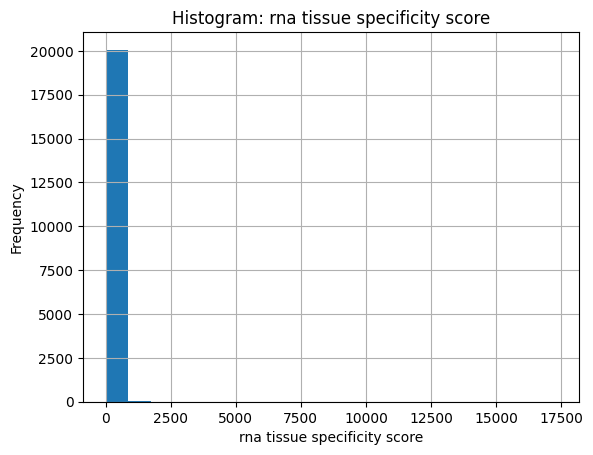


Hist Rna Single Cell Type Specificity Score


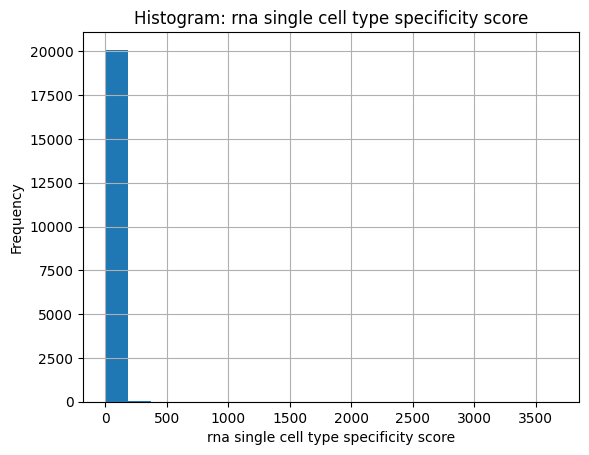


Hist Rna Single Nuclei Brain Specificity Score


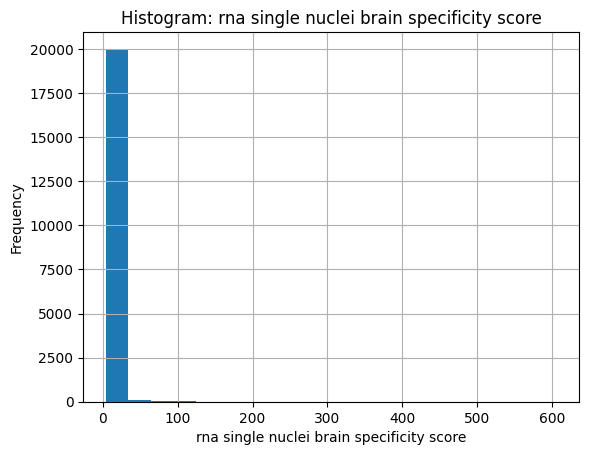


Hist Rna Cancer Specificity Score


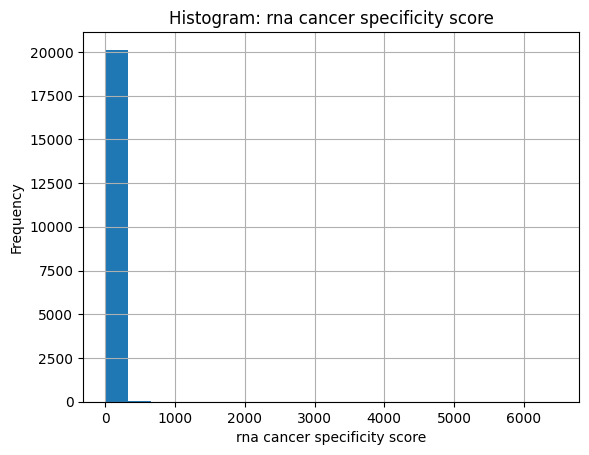


Hist Rna Blood Cell Specificity Score


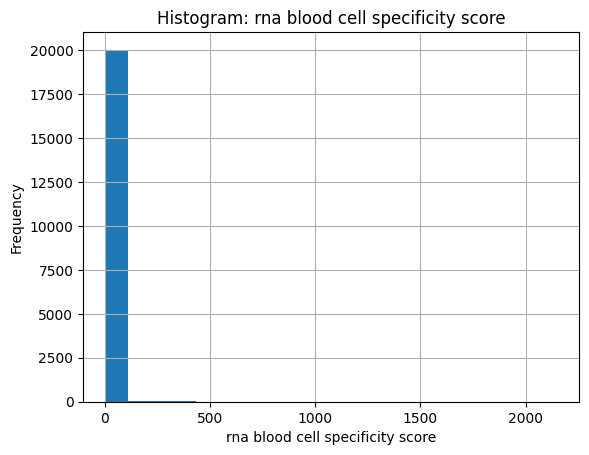


Hist Rna Blood Lineage Specificity Score


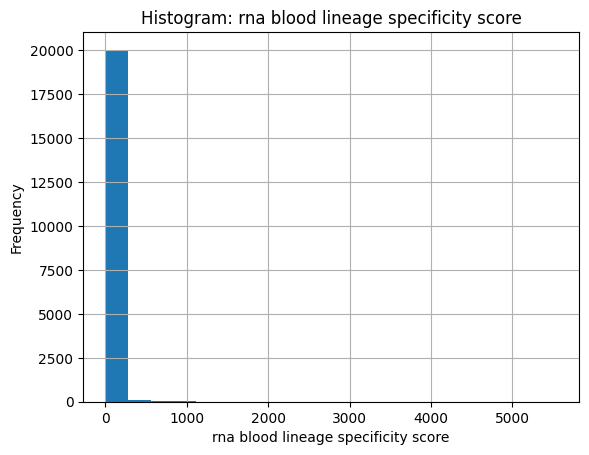


Hist Rna Cell Line Specificity Score


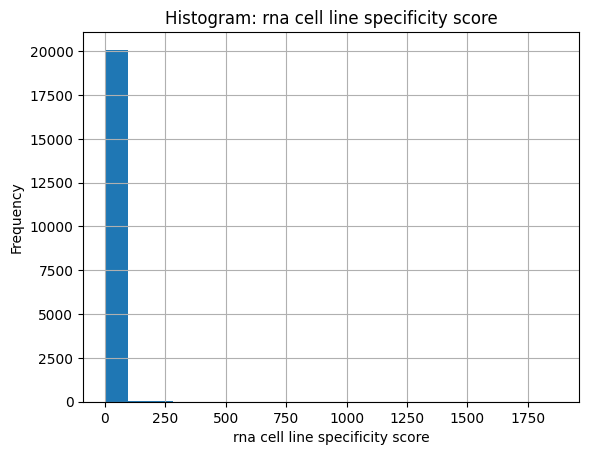


Hist Interactions


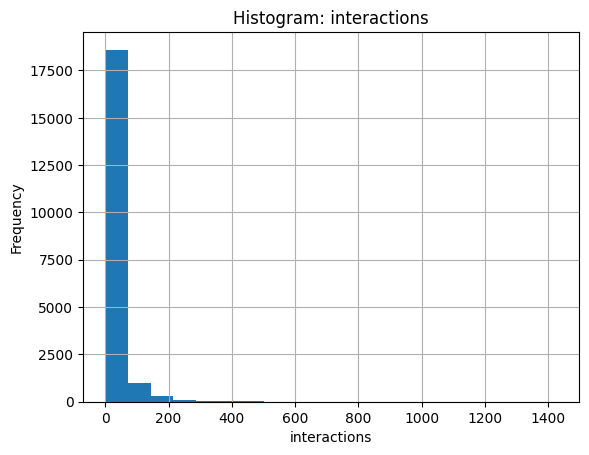


Box Rna Tissue Specificity Score


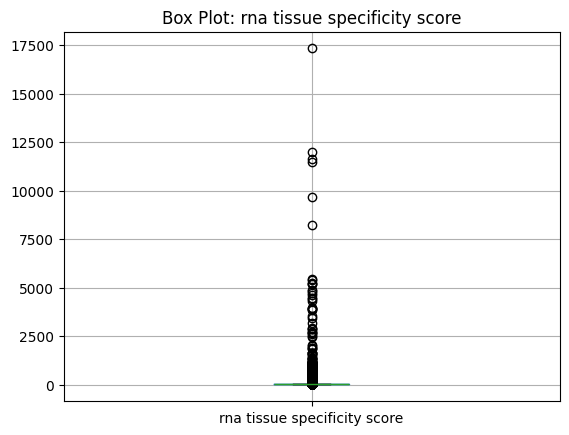


Box Rna Single Cell Type Specificity Score


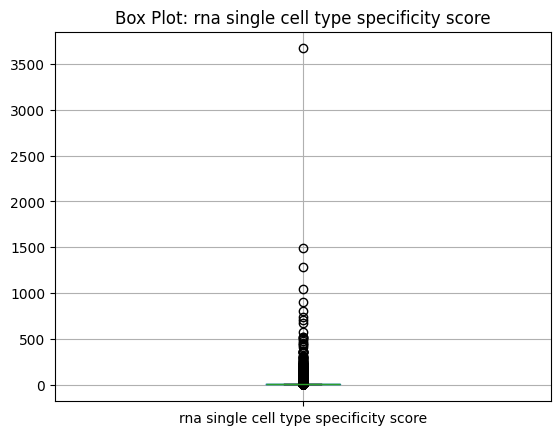


Box Rna Single Nuclei Brain Specificity Score


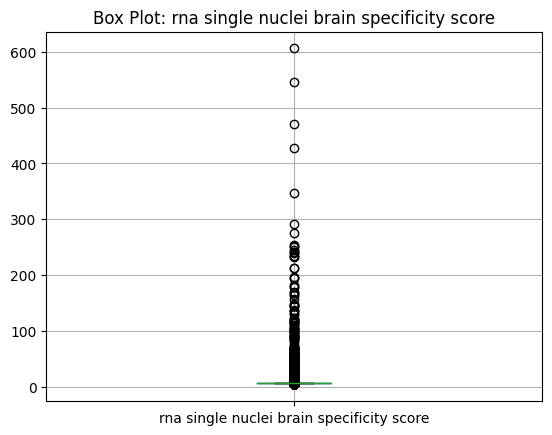


Box Rna Cancer Specificity Score


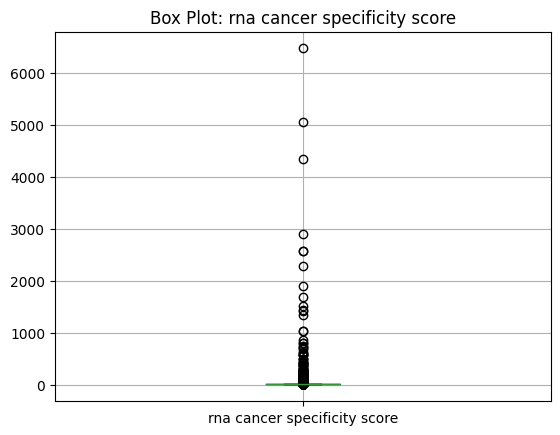


Box Rna Blood Cell Specificity Score


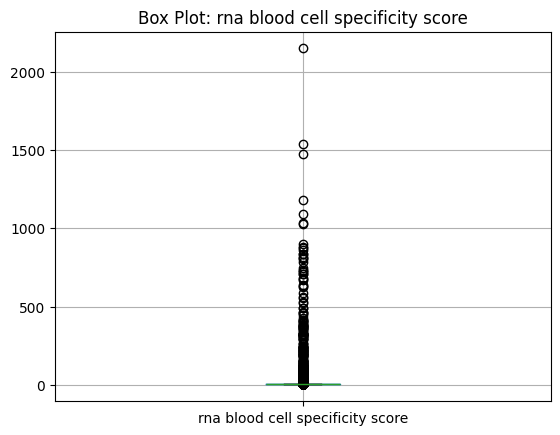


Box Rna Blood Lineage Specificity Score


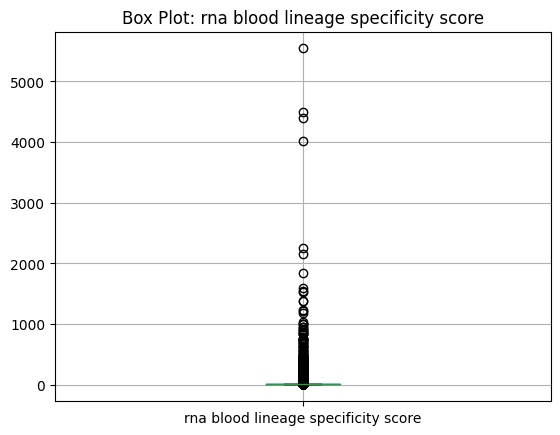


Box Rna Cell Line Specificity Score


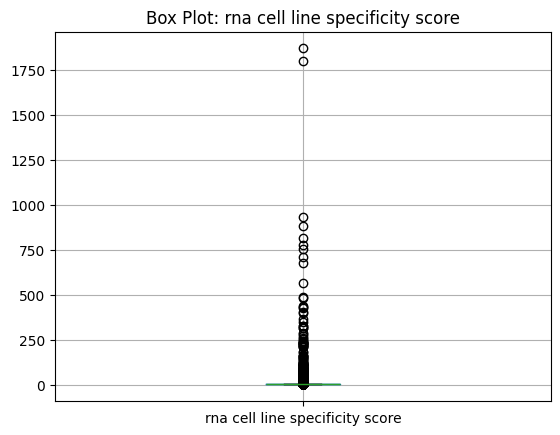


Box Interactions


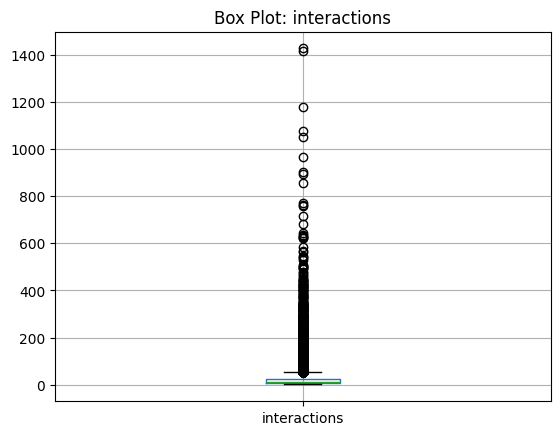


Correlation Heatmap


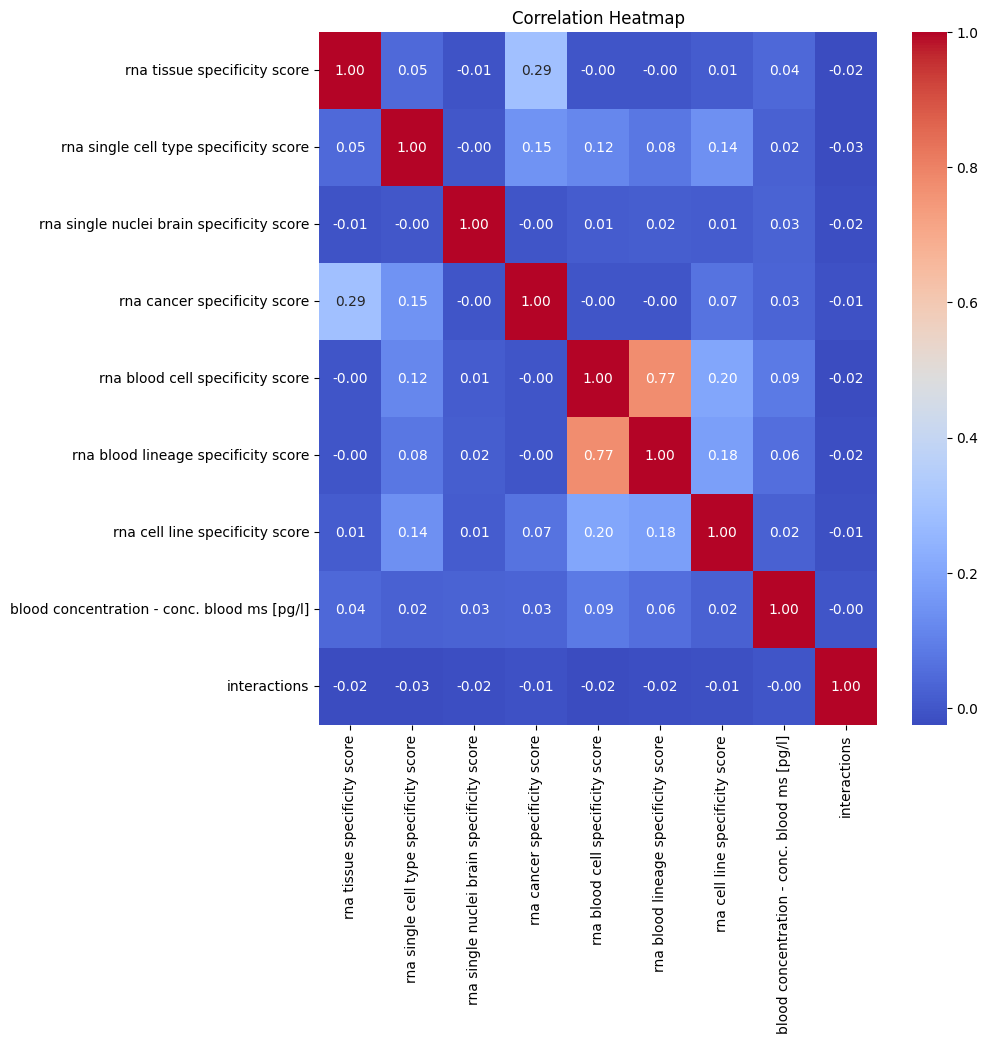

In [19]:
# Generate and display plots
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pathlib import Path

fig_paths = generate_plots(cleaned, "output/figures")
print(f"Generated {len(fig_paths)} figures\n")

# Show the plots inline
for path in fig_paths:
    print(Path(path).stem.replace('_', ' ').title())
    display(Image(filename=path, width=500))
    print()

---
## Part 7: The Full Agent — Putting It All Together

So far we called each tool manually. The real power of an agent is that the **LLM decides** what to do.

Our LangGraph workflow connects all the pieces:

```
Load CSV -> Inspect -> Decide Cleaning -> Clean (loop) -> EDA -> Report
```

The LLM:
- Reviews the issue report and decides which cleaning tools to call
- Can loop back for more cleaning if needed
- Analyzes EDA results and writes insights

This is the **ReAct pattern**: Reason + Act, in a loop.

In [20]:
from src.graph import build_graph
from src.models import AgentState

# Build the agent graph
graph = build_graph(llm)

# Prepare the initial state
initial_state: AgentState = {
    "file_path": CSV_PATH,
    "cleaning_iteration": 0,
    "max_cleaning_iterations": 3,
    "cleaning_log": [],
    "errors": [],
    "reasoning_log": [],
    "insights": [],
    "figure_paths": [],
    "needs_more_cleaning": False,
    "df": None,
    "original_shape": None,
    "profile": None,
    "issue_report": None,
    "eda_results": None,
    "report_path": None,
}

print("Running the full agent pipeline...")
print("(This may take 30-60 seconds depending on the LLM)\n")

result = graph.invoke(initial_state)

Running the full agent pipeline...
(This may take 30-60 seconds depending on the LLM)



In [21]:
result

{'file_path': '../../../Downloads/proteinatlas.tsv',
 'df':                   Gene                          Gene synonym          Ensembl  \
 0               TSPAN6                 T245, TM4SF6, TSPAN-6  ENSG00000000003   
 1                 TNMD  BRICD4, ChM1L, myodulin, TEM, tendin  ENSG00000000005   
 2                 DPM1                           CDGIE, MPDS  ENSG00000000419   
 3                SCYL3                         PACE-1, PACE1  ENSG00000000457   
 4             C1orf112                              FLJ10706  ENSG00000000460   
 ...                ...                                   ...              ...   
 20157  ENSG00000291313                                   NaN  ENSG00000291313   
 20158  ENSG00000291314                                   NaN  ENSG00000291314   
 20159  ENSG00000291315                                   NaN  ENSG00000291315   
 20160  ENSG00000291316                                   NaN  ENSG00000291316   
 20161          TMEM276                

In [22]:
# Check results
if result.get("report_path"):
    print(f"Report saved to: {result['report_path']}")
else:
    print("Report was not generated.")

if result.get("errors"):
    print(f"\nErrors encountered: {len(result['errors'])}")
    for err in result["errors"]:
        print(f"  - {err}")

Report saved to: output/report.md


In [ ]:
# Save the agent's reasoning log as a Markdown document
from src.report_generator import generate_reasoning_report

reasoning_path = generate_reasoning_report(
    reasoning_log=result.get("reasoning_log", []),
    errors=result.get("errors", []),
    output_dir="output",
)

In [24]:
# Display the generated report
from IPython.display import Markdown

if result.get("report_path"):
    with open(result["report_path"], "r") as f:
        report_content = f.read()
    display(Markdown(report_content))
else:
    print("No report to display.")

# Data Cleaning & EDA Report

## Dataset Overview

- **Original shape**: 20162 rows × 107 columns
- **Cleaned shape**: 20162 rows × 107 columns
- **Rows removed**: 0
- **Columns removed**: 0

## Issues Found

### Missing Values

| Column | Missing % |
|--------|-----------|
| Gene | 0.0% |
| Gene synonym | 15.8% |
| Ensembl | 0.0% |
| Gene description | 0.1% |
| Uniprot | 4.3% |
| Chromosome | 0.0% |
| Position | 0.0% |
| Protein class | 0.0% |
| Biological process | 46.2% |
| Molecular function | 45.3% |
| Disease involvement | 70.3% |
| Evidence | 0.0% |
| HPA evidence | 0.0% |
| UniProt evidence | 4.5% |
| NeXtProt evidence | 4.8% |
| RNA tissue specificity | 0.0% |
| RNA tissue distribution | 0.0% |
| RNA tissue specificity score | 76.5% |
| RNA tissue specific nTPM | 45.8% |
| RNA single cell type specificity | 0.4% |
| RNA single cell type distribution | 0.4% |
| RNA single cell type specificity score | 76.0% |
| RNA single cell type specific nTPM | 22.0% |
| RNA single nuclei brain specificity | 2.9% |
| RNA single nuclei brain distribution | 2.9% |
| RNA single nuclei brain specificity score | 88.1% |
| RNA single nuclei brain specific nTPM | 65.9% |
| RNA cancer specificity | 0.9% |
| RNA cancer distribution | 0.9% |
| RNA cancer specificity score | 89.7% |
| RNA cancer specific FPKM | 75.3% |
| RNA brain regional specificity | 0.0% |
| RNA brain regional distribution | 0.0% |
| RNA brain regional specificity score | 97.0% |
| RNA brain regional specific nTPM | 94.7% |
| RNA blood cell specificity | 0.0% |
| RNA blood cell distribution | 0.0% |
| RNA blood cell specificity score | 88.8% |
| RNA blood cell specific nTPM | 78.2% |
| RNA blood lineage specificity | 0.0% |
| RNA blood lineage distribution | 0.0% |
| RNA blood lineage specificity score | 83.2% |
| RNA blood lineage specific nTPM | 82.9% |
| RNA cell line specificity | 0.0% |
| RNA cell line distribution | 0.0% |
| RNA cell line specificity score | 89.1% |
| RNA cell line specific nTPM | 70.7% |
| RNA tissue cell type enrichment | 25.8% |
| RNA mouse brain regional specificity | 17.3% |
| RNA mouse brain regional distribution | 17.3% |
| RNA mouse brain regional specificity score | 97.5% |
| RNA mouse brain regional specific nTPM | 96.2% |
| RNA pig brain regional specificity | 17.6% |
| RNA pig brain regional distribution | 17.6% |
| RNA pig brain regional specificity score | 97.6% |
| RNA pig brain regional specific nTPM | 95.9% |
| Antibody | 13.8% |
| Reliability (IH) | 24.1% |
| Reliability (Mouse Brain) | 98.5% |
| Reliability (IF) | 32.9% |
| Subcellular location | 32.9% |
| Secretome location | 87.5% |
| Secretome function | 87.7% |
| CCD Protein | 92.6% |
| CCD Transcript | 91.9% |
| Blood concentration - Conc. blood IM [pg/L] | 97.8% |
| Blood concentration - Conc. blood MS [pg/L] | 78.7% |
| Blood expression cluster | 36.2% |
| Tissue expression cluster | 8.3% |
| Brain expression cluster | 11.6% |
| Cell line expression cluster | 3.2% |
| Single cell expression cluster | 4.8% |
| Interactions | 25.4% |
| Subcellular main location | 32.9% |
| Subcellular additional location | 69.5% |
| Antibody RRID | 13.8% |
| Cancer prognostics - Bladder Urothelial Carcinoma (TCGA) | 30.1% |
| Cancer prognostics - Breast Invasive Carcinoma (TCGA) | 29.3% |
| Cancer prognostics - Breast Invasive Carcinoma (validation) | 25.3% |
| Cancer prognostics - Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (TCGA) | 30.4% |
| Cancer prognostics - Colon Adenocarcinoma (TCGA) | 33.6% |
| Cancer prognostics - Colon Adenocarcinoma (validation) | 27.3% |
| Cancer prognostics - Glioblastoma Multiforme (TCGA) | 29.9% |
| Cancer prognostics - Glioblastoma Multiforme (validation) | 38.3% |
| Cancer prognostics - Head and Neck Squamous Cell Carcinoma (TCGA) | 32.5% |
| Cancer prognostics - Kidney Chromophobe (TCGA) | 35.8% |
| Cancer prognostics - Kidney Renal Clear Cell Carcinoma (TCGA) | 31.1% |
| Cancer prognostics - Kidney Renal Clear Cell Carcinoma (validation) | 30.2% |
| Cancer prognostics - Kidney Renal Papillary Cell Carcinoma (TCGA) | 31.6% |
| Cancer prognostics - Liver Hepatocellular Carcinoma (TCGA) | 37.6% |
| Cancer prognostics - Liver Hepatocellular Carcinoma (validation) | 42.3% |
| Cancer prognostics - Lung Adenocarcinoma (TCGA) | 28.8% |
| Cancer prognostics - Lung Adenocarcinoma (validation) | 29.0% |
| Cancer prognostics - Lung Squamous Cell Carcinoma (TCGA) | 29.5% |
| Cancer prognostics - Lung Squamous Cell Carcinoma (validation) | 29.2% |
| Cancer prognostics - Ovary Serous Cystadenocarcinoma (TCGA) | 31.0% |
| Cancer prognostics - Ovary Serous Cystadenocarcinoma (validation) | 32.1% |
| Cancer prognostics - Pancreatic Adenocarcinoma (TCGA) | 29.1% |
| Cancer prognostics - Pancreatic Adenocarcinoma (validation) | 32.8% |
| Cancer prognostics - Prostate Adenocarcinoma (TCGA) | 32.5% |
| Cancer prognostics - Rectum Adenocarcinoma (TCGA) | 34.1% |
| Cancer prognostics - Rectum Adenocarcinoma (validation) | 27.0% |
| Cancer prognostics - Skin Cuteneous Melanoma (TCGA) | 33.3% |
| Cancer prognostics - Stomach Adenocarcinoma (TCGA) | 28.5% |
| Cancer prognostics - Testicular Germ Cell Tumor (TCGA) | 27.0% |
| Cancer prognostics - Thyroid Carcinoma (TCGA) | 33.8% |
| Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA) | 29.4% |

### Duplicate Rows

- **0** duplicate rows detected

### Outliers

| Column | Outlier Count |
|--------|---------------|
| RNA tissue specificity score | 729 |
| RNA single cell type specificity score | 653 |
| RNA single nuclei brain specificity score | 295 |
| RNA cancer specificity score | 282 |
| RNA brain regional specificity score | 62 |
| RNA blood cell specificity score | 326 |
| RNA blood lineage specificity score | 473 |
| RNA cell line specificity score | 281 |
| RNA mouse brain regional specificity score | 64 |
| RNA pig brain regional specificity score | 56 |
| Blood concentration - Conc. blood IM [pg/L] | 99 |
| Blood concentration - Conc. blood MS [pg/L] | 824 |
| Interactions | 1341 |

### Inconsistent Types

- Chromosome

### High Cardinality Columns

- Gene
- Gene synonym
- Ensembl
- Gene description
- Uniprot
- Position
- RNA tissue specific nTPM
- RNA single cell type specific nTPM
- RNA single nuclei brain specific nTPM
- RNA cancer specific FPKM
- RNA brain regional specific nTPM
- RNA blood cell specific nTPM
- RNA blood lineage specific nTPM
- RNA cell line specific nTPM
- RNA mouse brain regional specific nTPM
- RNA pig brain regional specific nTPM
- Antibody
- Antibody RRID

## Cleaning Actions

No cleaning actions were performed.


## Key Statistics

### Numeric Statistics

```
       RNA tissue specificity score  RNA single cell type specificity score  RNA single nuclei brain specificity score  RNA cancer specificity score  RNA brain regional specificity score  RNA blood cell specificity score  RNA blood lineage specificity score  RNA cell line specificity score  RNA mouse brain regional specificity score  RNA pig brain regional specificity score  Blood concentration - Conc. blood IM [pg/L]  Blood concentration - Conc. blood MS [pg/L]  Interactions
count                   4733.000000                             4841.000000                                2408.000000                   2067.000000                            595.000000                       2265.000000                          3394.000000                      2198.000000                                  497.000000                                479.000000                                 4.530000e+02                                 4.294000e+03  15038.000000
mean                      93.863723                               20.688081                                  15.382890                     41.787615                             10.252101                         37.804857                            48.826458                        22.126479                                   11.247485                                 15.321503                                 1.720923e+11                                 1.898230e+09     31.345591
std                      552.073489                               77.370493                                  34.774273                    258.302553                             24.113445                        123.183300                           207.685446                        82.245602                                   18.474948                                 53.858378                                 2.101224e+12                                 1.497447e+10     58.975225
min                        4.000000                                4.000000                                   4.000000                      4.000000                              4.000000                          4.000000                             4.000000                         4.000000                                    4.000000                                  4.000000                                 1.700000e+03                                 1.600000e+03      1.000000
25%                        5.000000                                4.000000                                   4.000000                      5.000000                              5.000000                          5.000000                             5.000000                         5.000000                                    5.000000                                  5.000000                                 2.490000e+05                                 5.700000e+04      4.000000
50%                        9.000000                                6.000000                                   6.000000                      7.000000                              6.000000                          7.000000                             9.000000                         7.000000                                    6.000000                                  6.000000                                 6.500000e+06                                 6.100000e+05     13.000000
75%                       26.000000                               13.000000                                  12.000000                     13.000000                             10.000000                         17.000000                            24.000000                        13.000000                                   10.000000                                 10.000000                                 6.570000e+08                                 1.200000e+07     35.000000
max                    17324.000000                             3668.000000                                 606.000000                   6472.000000                            542.000000                       2147.000000                          5543.000000                      1869.000000                                  230.000000                                892.000000                                 4.000000e+13                                 3.700000e+11   1427.000000
```

### Categorical Statistics

```
Column: Gene
Gene
MKKS       3
MATR3      2
PRODH      2
HERC3      2
TMSB15B    2
POLR2J3    2
NPIPA9     2
PINX1      2
NOX5       2
TBCE       2

Column: Gene synonym
Gene synonym
CD1                                     3
AMY1                                    3
IGLC                                    3
PRKAR2                                  2
SBBI31                                  2
SAS                                     2
HSPOX2, PIG6, PRODH1, PRODH2, TP53I6    2
CLP                                     2
CAV                                     2
NAG                                     2

Column: Ensembl
Ensembl
ENSG00000000003    1
ENSG00000000005    1
ENSG00000000419    1
ENSG00000000457    1
ENSG00000000460    1
ENSG00000000938    1
ENSG00000000971    1
ENSG00000001036    1
ENSG00000001084    1
ENSG00000001167    1

Column: Gene description
Gene description
Novel protein                                                   265
Novel transcript                                                  6
Novel zinc finger protein                                         4
MKKS centrosomal shuttling protein                                3
Matrin 3                                                          2
Proline dehydrogenase 1                                           2
Mitochondrial elongation factor 1                                 2
Phosphodiesterase 8B                                              2
HECT and RLD domain containing E3 ubiquitin protein ligase 3      2
Thymosin beta 15B                                                 2

Column: Uniprot
Uniprot
P62805                                        14
Q5JQC4                                        12
P68431                                        10
Q0WX57                                         7
Q9ULZ0                                         6
P62807                                         5
P0C0S8                                         5
A0A1W2PP81, P0DW11, P0DW12, P0DW13, P0DW14     5
P0DN86                                         3
Q71DI3                                         3

Column: Chromosome
Chromosome
1     2038
19    1435
11    1302
2     1281
17    1160
3     1065
6     1033
12    1018
7     1002
5      872

Column: Position
Position
88520998-88523776      2
69118010-69132588      2
100627108-100639991    1
100584936-100599885    1
50934867-50959140      1
169849631-169894267    1
169662007-169854080    1
27612064-27635185      1
196651754-196752476    1
143494812-143511720    1

Column: Protein class
Protein class
Predicted intracellular proteins                                                        5292
Predicted intracellular proteins, Transcription factors                                  860
Predicted membrane proteins                                                              845
Disease related genes, Human disease related genes, Predicted intracellular proteins     793
Plasma proteins, Predicted intracellular proteins                                        696
Predicted intracellular proteins, Predicted membrane proteins                            610
Enzymes, Predicted intracellular proteins                                                564
Enzymes, Metabolic proteins, Predicted intracellular proteins                            516
G-protein coupled receptors, Predicted membrane proteins                                 472
Predicted secreted proteins                                                              380

Column: Biological process
Biological process
Transcription, Transcription regulation    1480
Ubl conjugation pathway                     358
Olfaction, Sensory transduction             353
Adaptive immunity, Immunity                 328
Cell adhesion                               309
Protein transport, Transport                268
Lipid metabolism                            202
Transport                                   194
Apoptosis                                   180
mRNA processing, mRNA splicing              174

Column: Molecular function
Molecular function
DNA-binding                                             910
G-protein coupled receptor, Receptor, Transducer        711
Hydrolase                                               492
Transferase                                             418
Receptor                                                418
Developmental protein                                   344
Oxidoreductase                                          311
RNA-binding                                             269
Kinase, Serine/threonine-protein kinase, Transferase    267
Activator, DNA-binding                                  214

Column: Disease involvement
Disease involvement
Disease variant                                    898
Cancer-related genes                               801
FDA approved drug targets                          341
Disease variant, Intellectual disability           251
Cancer-related genes, Disease variant              142
Disease variant, Primary mitochondrial disease     107
Disease variant, FDA approved drug targets          96
Tumor suppressor                                    90
Cancer-related genes, FDA approved drug targets     86
Cancer-related genes, Proto-oncogene                75

Column: Evidence
Evidence
Evidence at protein level               18527
Evidence at transcript level             1376
No human protein/transcript evidence      259

Column: HPA evidence
HPA evidence
Evidence at protein level               11363
Evidence at transcript level             8246
No human protein/transcript evidence      553

Column: UniProt evidence
UniProt evidence
Evidence at protein level               16438
Evidence at transcript level             2054
No human protein/transcript evidence      759

Column: NeXtProt evidence
NeXtProt evidence
Evidence at protein level               18188
Evidence at transcript level              877
No human protein/transcript evidence      127

Column: RNA tissue specificity
RNA tissue specificity
Low tissue specificity    8194
Tissue enhanced           6197
Tissue enriched           3150
Group enriched            1583
Not detected              1038

Column: RNA tissue distribution
RNA tissue distribution
Detected in all       8899
Detected in many      5803
Detected in some      3297
Detected in single    1125
Not detected          1038

Column: RNA tissue specific nTPM
RNA tissue specific nTPM
testis: 1.1    14
brain: 2.8     10
testis: 1.6    10
testis: 1.3    10
testis: 2.8     9
testis: 2.7     8
testis: 4.9     7
testis: 4.8     7
testis: 1.0     7
testis: 3.3     7

Column: RNA single cell type specificity
RNA single cell type specificity
Cell type enhanced           10879
Low cell type specificity     3072
Group enriched                2732
Cell type enriched            2109
Not detected                  1290

Column: RNA single cell type distribution
RNA single cell type distribution
Detected in many      8464
Detected in all       5000
Detected in some      4963
Not detected          1290
Detected in single     365

Column: RNA single cell type specific nTPM
RNA single cell type specific nTPM
Oocytes: 1.5                     8
Melanocytes: 1.7                 7
Cone photoreceptor cells: 1.7    6
Horizontal cells: 1.3            5
Oocytes: 165.4                   4
Early spermatids: 1.3            4
T-cells: 3.1                     4
Plasma cells: 1.2                4
Oocytes: 7.4                     3
Oocytes: 75.0                    3

Column: RNA single nuclei brain specificity
RNA single nuclei brain specificity
Low cell type specificity    9920
Cell type enhanced           4476
Not detected                 2776
Cell type enriched           1258
Group enriched               1150

Column: RNA single nuclei brain distribution
RNA single nuclei brain distribution
Detected in all       10507
Detected in many       3753
Not detected           2776
Detected in some       1953
Detected in single      591

Column: RNA single nuclei brain specific nTPM
RNA single nuclei brain specific nTPM
leukocyte: 1.2            6
bergmann glia: 1.1        6
leukocyte: 2.9            5
endothelial cell: 1.1     5
leukocyte: 9.0            5
leukocyte: 2.8            5
leukocyte: 2.0            5
leukocyte: 2.5            4
leukocyte: 2.4            4
upper rhombic lip: 1.0    4

Column: RNA cancer specificity
RNA cancer specificity
Low cancer specificity    12535
Cancer enhanced            2915
Not detected               2456
Cancer enriched            1311
Group enriched              756

Column: RNA cancer distribution
RNA cancer distribution
Detected in all       10574
Detected in many       4082
Not detected           2456
Detected in some       1971
Detected in single      890

Column: RNA cancer specific FPKM
RNA cancer specific FPKM
Testicular Germ Cell Tumor (TCGA): 1.1              13
Testicular Germ Cell Tumor (TCGA): 1.3              11
Testicular Germ Cell Tumor (TCGA): 1.2              11
Testicular Germ Cell Tumor (TCGA): 1.8               9
Testicular Germ Cell Tumor (TCGA): 1.0               9
Testicular Germ Cell Tumor (TCGA): 1.4               9
Testicular Germ Cell Tumor (TCGA): 2.4               8
Testicular Germ Cell Tumor (TCGA): 1.5               7
Glioblastoma Multiforme (TCGA): 1.2                  6
Uterine Corpus Endometrial Carcinoma (TCGA): 1.1     6

Column: RNA brain regional specificity
RNA brain regional specificity
Low region specificity    16768
Not detected               2330
Region enhanced             469
Region enriched             409
Group enriched              186

Column: RNA brain regional distribution
RNA brain regional distribution
Detected in all       15005
Not detected           2330
Detected in many       1744
Detected in some        640
Detected in single      443

Column: RNA brain regional specific nTPM
RNA brain regional specific nTPM
cerebral cortex: 1.1    5
choroid plexus: 1.5     5
cerebral cortex: 1.2    5
choroid plexus: 8.5     3
choroid plexus: 23.9    3
choroid plexus: 21.0    3
cerebellum: 7.4         3
cerebellum: 20.3        3
choroid plexus: 33.6    3
choroid plexus: 1.3     3

Column: RNA blood cell specificity
RNA blood cell specificity
Low immune cell specificity     8437
Not detected in immune cells    7331
Immune cell enhanced            2129
Group enriched                  1252
Immune cell enriched            1013

Column: RNA blood cell distribution
RNA blood cell distribution
Not detected          7331
Detected in all       5771
Detected in many      4070
Detected in some      1846
Detected in single    1144

Column: RNA blood cell specific nTPM
RNA blood cell specific nTPM
basophil: 1.0           16
basophil: 1.3           15
neutrophil: 1.1         14
neutrophil: 1.3         13
plasmacytoid DC: 1.3    13
neutrophil: 1.4         12
plasmacytoid DC: 1.6    11
plasmacytoid DC: 1.0    11
basophil: 1.1           11
neutrophil: 2.0         10

Column: RNA blood lineage specificity
RNA blood lineage specificity
Low lineage specificity    9389
Not detected               7331
Lineage enriched           2197
Group enriched             1197
Lineage enhanced             48

Column: RNA blood lineage distribution
RNA blood lineage distribution
Detected in all       7593
Not detected          7331
Detected in many      3431
Detected in single    1807

Column: RNA blood lineage specific nTPM
RNA blood lineage specific nTPM
granulocytes: 1.0    18
granulocytes: 1.3    15
granulocytes: 1.5    14
granulocytes: 2.0    13
T-cells: 1.1         13
granulocytes: 1.9    13
granulocytes: 2.5    12
granulocytes: 1.1    12
granulocytes: 3.3    10
T-cells: 1.4          9

Column: RNA cell line specificity
RNA cell line specificity
Low cancer specificity    11651
Cancer enhanced            3709
Not detected               2604
Cancer enriched            1324
Group enriched              874

Column: RNA cell line distribution
RNA cell line distribution
Detected in all       9571
Detected in many      4379
Detected in some      2651
Not detected          2604
Detected in single     957

Column: RNA cell line specific nTPM
RNA cell line specific nTPM
Leukemia: 1.0         12
lymphoma: 1.1          9
lymphoma: 1.0          8
Leukemia: 1.4          8
Neuroblastoma: 5.6     7
Bone cancer: 1.1       6
Neuroblastoma: 1.3     6
Leukemia: 1.2          6
lymphoma: 1.9          6
Leukemia: 2.4          6

Column: RNA tissue cell type enrichment
RNA tissue cell type enrichment
Testis - Early spermatids                              716
Testis - Early spermatids, Testis - Late spermatids    599
Testis - Spermatocytes                                 325
Testis - Late spermatids                               310
Adrenal gland - Adrenal cortex cells                   262
Thyroid gland - Thyroid glandular cells                234
Testis - Spermatogonia                                 185
Testis - Spermatocytes, Testis - Spermatogonia         153
Liver - Hepatocytes                                    143
Heart muscle - Cardiomyocytes                          129

Column: RNA mouse brain regional specificity
RNA mouse brain regional specificity
Low region specificity    12968
Not detected               2948
Region enriched             333
Region enhanced             266
Group enriched              164

Column: RNA mouse brain regional distribution
RNA mouse brain regional distribution
Detected in all       11317
Not detected           2948
Detected in many       1520
Detected in single      470
Detected in some        424

Column: RNA mouse brain regional specific nTPM
RNA mouse brain regional specific nTPM
olfactory bulb: 1.9      5
cerebellum: 2.3          4
cerebellum: 1.0          4
olfactory bulb: 1.2      4
hypothalamus: 1.7        4
pons and medulla: 1.4    4
pons and medulla: 1.1    4
basal ganglia: 1.5       4
cerebellum: 2.4          3
basal ganglia: 1.2       3

Column: RNA pig brain regional specificity
RNA pig brain regional specificity
Low region specificity    14211
Not detected               1567
Region enhanced             357
Region enriched             295
Group enriched              184

Column: RNA pig brain regional distribution
RNA pig brain regional distribution
Detected in all       12783
Not detected           1567
Detected in many       1464
Detected in some        463
Detected in single      337

Column: RNA pig brain regional specific nTPM
RNA pig brain regional specific nTPM
spinal cord: 3.3        4
spinal cord: 3.1        3
cerebellum: 2.0         3
cerebral cortex: 1.3    3
cerebral cortex: 1.5    3
cerebellum: 6.6         3
spinal cord: 2.4        3
midbrain: 1.6           3
basal ganglia: 1.3      3
spinal cord: 13.2       3

Column: Antibody
Antibody
HPA045642                          25
HPA048721                          22
HPA060078                          21
HPA051750                          18
HPA042205, HPA043013, HPA048671    16
HPA041189                          16
HPA053611                          16
HPA042483                          15
HPA008755, HPA010580               14
HPA047557                          13

Column: Reliability (IH)
Reliability (IH)
Approved     5554
Uncertain    4158
Enhanced     3931
Supported    1659

Column: Reliability (Mouse Brain)
Reliability (Mouse Brain)
Supported    233
Approved      70

Column: Reliability (IF)
Reliability (IF)
Approved     6927
Supported    4547
Enhanced     1279
Uncertain     781

Column: Subcellular location
Subcellular location
Nucleoplasm                1603
Nucleoplasm,Cytosol        1041
Cytosol                     900
Vesicles                    680
Mitochondria                536
Plasma membrane,Cytosol     356
Plasma membrane             334
Nucleoplasm,Nucleoli        279
Nucleoplasm,Vesicles        273
Golgi apparatus             270

Column: Secretome location
Secretome location
Secreted to blood                         785
Intracellular and membrane                619
Secreted in other tissues                 286
Secreted to extracellular matrix          236
Immunoglobulin genes                      147
Secreted in male reproductive system      123
Secreted - unknown location               116
Secreted to digestive system               94
Secreted in brain                          76
Secreted in female reproductive system     38

Column: Secretome function
Secretome function
Enzyme                   505
No annotated function    499
Immunity                 224
Receptor                 170
Other                    168
Developmental protein    131
Cell adhesion            119
Hormone                   93
Cytokine                  73
Enzyme inhibitor          69

Column: CCD Protein
CCD Protein
No     786
Yes    702

Column: CCD Transcript
CCD Transcript
No     1104
Yes     530

Column: Blood expression cluster
Blood expression cluster
Cluster 33: Non-specific - ATP binding                  757
Cluster 5: Non-specific - Cell proliferation            689
Cluster 12: Non-specific - Mitochondrial translation    566
Cluster 42: Non-specific - Vesicular transport          519
Cluster 24: Non-specific - Transcription                516
Cluster 35: Neutrophils - Protein binding               504
Cluster 38: Monocytes & Neutrophils - Degranulation     501
Cluster 21: Neutrophils - Unknown function              492
Cluster 3: Non-specific - Nuclear processes             471
Cluster 13: Non-specific - Mitochondria                 458

Column: Tissue expression cluster
Tissue expression cluster
Cluster 16: Non-specific - Transcription               690
Cluster 19: Non-specific - Basic cellular processes    569
Cluster 66: Non-specific - Transcription               492
Cluster 40: Non-specific - Transcription               474
Cluster 9: Oligodendrocytes - Myelination              457
Cluster 70: Lymphoid tissue - Immune response          420
Cluster 35: Non-specific - Mitochondria                391
Cluster 62: Connective tissue - ECM organization       389
Cluster 8: Ciliated cells - Cilium organization        384
Cluster 44: Testis - Spermatogenesis                   384

Column: Brain expression cluster
Brain expression cluster
Cluster 28: Oligodendrocytes - Mixed function     601
Cluster 11: White matter - Signal transduction    593
Cluster 21: Non-specific - Metabolism             571
Cluster 51: Neurons - Mixed function              530
Cluster 53: Neurons - Mixed function              527
Cluster 6: Non-specific - Immune response         524
Cluster 14: Neurons - Synaptic function           515
Cluster 15: Non-specific - Transcription          490
Cluster 25: Non-specific - Transcription          477
Cluster 23: Choroid plexus - Mixed function       469

Column: Cell line expression cluster
Cell line expression cluster
Cluster 53: Squamous epithelial cells - Keratinization    967
Cluster 15: Kidney cancer - Membrane components           689
Cluster 27: Breast cancer - Unknown function              687
Cluster 51: Myeloma - Immunoglobulins                     676
Cluster 10: Ciliated cells - Ion channel activity         610
Cluster 64: Connective tissue cells - ECM organization    527
Cluster 4: Non-specific - Transcription                   500
Cluster 46: Lymphoma - Humoral immune response            454
Cluster 14: Myeloid leukemia - Innate immune response     453
Cluster 72: Neuronal - Signal transduction                444

Column: Single cell expression cluster
Single cell expression cluster
Cluster 39: Non-specific - Basic cellular processes               835
Cluster 55: Non-specific - Transcription                          709
Cluster 34: Neurons - Neuronal signaling                          518
Cluster 29: Monocytes - Innate immune response                    447
Cluster 11: Late spermatids - Unknown function                    430
Cluster 42: Ciliated cells - Cilium assembly                      429
Cluster 36: Late spermatids - Unknown function                    427
Cluster 58: Macrophages - Innate immune response                  420
Cluster 78: NK-cells & T-cells - Immune system & Transcription    392
Cluster 63: Late spermatids - Spermatogenesis                     383

Column: Subcellular main location
Subcellular main location
Nucleoplasm                 3317
Cytosol                     1587
Vesicles                    1032
Mitochondria                 789
Plasma membrane              779
Golgi apparatus              539
Nucleoplasm, Cytosol         444
Plasma membrane, Cytosol     344
Endoplasmic reticulum        319
Nuclear speckles             297

Column: Subcellular additional location
Subcellular additional location
Cytosol                 1149
Nucleoplasm              765
Vesicles                 380
Plasma membrane          258
Nucleoli                 236
Nucleoplasm, Cytosol     180
Golgi apparatus          173
Nuclear bodies           140
Mitochondria              91
Vesicles, Cytosol         82

Column: Antibody RRID
Antibody RRID
HPA045642: AB_2679403                                                  25
HPA048721:                                                             22
HPA060078:                                                             21
HPA051750: AB_2681590                                                  18
HPA042205: AB_2677900, HPA043013: AB_2678269, HPA048671: AB_2680488    16
HPA041189: AB_2677357                                                  16
HPA053611: AB_2682206                                                  16
HPA042483: AB_2678017                                                  15
HPA008755: AB_1079577, HPA010580: AB_2732401                           14
HPA047557: AB_2680087                                                  13

Column: Cancer prognostics - Bladder Urothelial Carcinoma (TCGA)
Cancer prognostics - Bladder Urothelial Carcinoma (TCGA)
unprognostic (1.01e-1)    46
unprognostic (1.04e-1)    44
unprognostic (1.18e-1)    44
unprognostic (1.29e-1)    42
unprognostic (1.03e-1)    42
unprognostic (1.06e-1)    42
unprognostic (1.07e-1)    41
unprognostic (1.12e-1)    39
unprognostic (1.37e-1)    39
unprognostic (1.16e-1)    38

Column: Cancer prognostics - Breast Invasive Carcinoma (TCGA)
Cancer prognostics - Breast Invasive Carcinoma (TCGA)
unprognostic (1.08e-1)    54
unprognostic (1.03e-1)    47
unprognostic (1.01e-1)    44
unprognostic (1.20e-1)    42
unprognostic (1.19e-1)    42
unprognostic (1.09e-1)    41
unprognostic (1.05e-1)    41
unprognostic (1.07e-1)    41
unprognostic (1.16e-1)    40
unprognostic (1.18e-1)    40

Column: Cancer prognostics - Breast Invasive Carcinoma (validation)
Cancer prognostics - Breast Invasive Carcinoma (validation)
unprognostic (1.21e-1)    54
unprognostic (1.08e-1)    54
unprognostic (1.06e-1)    53
unprognostic (1.12e-1)    53
unprognostic (1.18e-1)    51
unprognostic (1.07e-1)    49
unprognostic (1.04e-1)    48
unprognostic (1.25e-1)    48
unprognostic (1.03e-1)    48
unprognostic (1.49e-1)    46

Column: Cancer prognostics - Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (TCGA)
Cancer prognostics - Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (TCGA)
unprognostic (1.17e-1)    44
unprognostic (1.08e-1)    44
unprognostic (1.24e-1)    42
unprognostic (1.07e-1)    41
unprognostic (1.09e-1)    40
unprognostic (1.38e-1)    40
unprognostic (1.14e-1)    40
unprognostic (1.10e-1)    39
unprognostic (1.35e-1)    38
unprognostic (1.30e-1)    38

Column: Cancer prognostics - Colon Adenocarcinoma (TCGA)
Cancer prognostics - Colon Adenocarcinoma (TCGA)
unprognostic (1.12e-1)    54
unprognostic (1.22e-1)    53
unprognostic (1.25e-1)    53
unprognostic (1.20e-1)    48
unprognostic (1.03e-1)    47
unprognostic (1.02e-1)    46
unprognostic (1.08e-1)    46
unprognostic (1.09e-1)    45
unprognostic (1.07e-1)    45
unprognostic (1.49e-1)    44

Column: Cancer prognostics - Colon Adenocarcinoma (validation)
Cancer prognostics - Colon Adenocarcinoma (validation)
unprognostic (1.03e-1)    61
unprognostic (1.05e-1)    54
unprognostic (1.66e-1)    52
unprognostic (1.37e-1)    50
unprognostic (1.09e-1)    50
unprognostic (1.31e-1)    50
unprognostic (1.48e-1)    49
unprognostic (1.07e-1)    49
unprognostic (1.18e-1)    48
unprognostic (1.33e-1)    47

Column: Cancer prognostics - Glioblastoma Multiforme (TCGA)
Cancer prognostics - Glioblastoma Multiforme (TCGA)
unprognostic (1.05e-1)    58
unprognostic (1.16e-1)    56
unprognostic (1.15e-1)    54
unprognostic (1.14e-1)    54
unprognostic (1.25e-1)    51
unprognostic (1.08e-1)    50
unprognostic (1.03e-1)    49
unprognostic (1.18e-1)    49
unprognostic (1.11e-1)    49
unprognostic (1.02e-1)    48

Column: Cancer prognostics - Glioblastoma Multiforme (validation)
Cancer prognostics - Glioblastoma Multiforme (validation)
unprognostic (1.01e-1)    37
unprognostic (1.31e-1)    36
unprognostic (1.04e-1)    33
unprognostic (1.27e-1)    32
unprognostic (1.14e-1)    32
unprognostic (1.03e-1)    32
unprognostic (1.11e-1)    31
unprognostic (1.47e-1)    30
unprognostic (1.18e-1)    30
unprognostic (1.15e-1)    29

Column: Cancer prognostics - Head and Neck Squamous Cell Carcinoma (TCGA)
Cancer prognostics - Head and Neck Squamous Cell Carcinoma (TCGA)
unprognostic (1.22e-1)    45
unprognostic (1.13e-1)    45
unprognostic (1.02e-1)    44
unprognostic (1.18e-1)    38
unprognostic (1.11e-1)    38
unprognostic (1.04e-1)    37
unprognostic (1.39e-1)    37
unprognostic (1.09e-1)    37
unprognostic (1.21e-1)    37
unprognostic (1.38e-1)    36

Column: Cancer prognostics - Kidney Chromophobe (TCGA)
Cancer prognostics - Kidney Chromophobe (TCGA)
unprognostic (1.05e-1)    40
unprognostic (1.03e-1)    39
unprognostic (1.44e-1)    38
unprognostic (1.12e-1)    37
unprognostic (1.11e-1)    36
unprognostic (1.24e-1)    36
unprognostic (1.04e-1)    34
unprognostic (1.09e-1)    34
unprognostic (1.92e-1)    33
unprognostic (1.06e-1)    33

Column: Cancer prognostics - Kidney Renal Clear Cell Carcinoma (TCGA)
Cancer prognostics - Kidney Renal Clear Cell Carcinoma (TCGA)
unprognostic (1.12e-1)    18
unprognostic (1.06e-3)    18
unprognostic (1.11e-2)    16
unprognostic (1.01e-1)    16
unprognostic (1.49e-1)    15
unprognostic (1.05e-2)    14
unprognostic (1.14e-1)    14
unprognostic (1.43e-2)    14
unprognostic (2.29e-2)    14
unprognostic (1.17e-1)    14

Column: Cancer prognostics - Kidney Renal Clear Cell Carcinoma (validation)
Cancer prognostics - Kidney Renal Clear Cell Carcinoma (validation)
unprognostic (1.09e-1)    38
unprognostic (1.20e-1)    34
unprognostic (1.01e-1)    33
unprognostic (1.12e-1)    33
unprognostic (1.18e-1)    32
unprognostic (1.36e-1)    31
unprognostic (1.39e-1)    30
unprognostic (1.08e-1)    29
unprognostic (1.03e-1)    28
unprognostic (1.11e-1)    28

Column: Cancer prognostics - Kidney Renal Papillary Cell Carcinoma (TCGA)
Cancer prognostics - Kidney Renal Papillary Cell Carcinoma (TCGA)
unprognostic (1.03e-1)    47
unprognostic (1.01e-1)    46
unprognostic (1.35e-1)    41
unprognostic (1.12e-1)    40
unprognostic (1.18e-1)    35
unprognostic (1.22e-1)    35
unprognostic (1.08e-1)    35
unprognostic (1.07e-1)    34
unprognostic (1.04e-1)    34
unprognostic (1.26e-1)    33

Column: Cancer prognostics - Liver Hepatocellular Carcinoma (TCGA)
Cancer prognostics - Liver Hepatocellular Carcinoma (TCGA)
unprognostic (1.01e-1)    24
unprognostic (1.22e-1)    24
unprognostic (1.17e-1)    23
unprognostic (1.46e-1)    23
unprognostic (1.58e-1)    23
unprognostic (1.39e-1)    22
unprognostic (1.03e-1)    22
unprognostic (1.09e-1)    22
unprognostic (1.02e-1)    22
unprognostic (1.35e-1)    22

Column: Cancer prognostics - Liver Hepatocellular Carcinoma (validation)
Cancer prognostics - Liver Hepatocellular Carcinoma (validation)
unprognostic (1.11e-1)    37
unprognostic (1.13e-1)    30
unprognostic (1.20e-1)    28
unprognostic (1.09e-1)    28
unprognostic (1.15e-1)    27
unprognostic (1.17e-1)    26
unprognostic (1.08e-1)    26
unprognostic (1.02e-1)    25
unprognostic (1.23e-1)    24
unprognostic (1.63e-1)    24

Column: Cancer prognostics - Lung Adenocarcinoma (TCGA)
Cancer prognostics - Lung Adenocarcinoma (TCGA)
unprognostic (1.18e-1)    41
unprognostic (1.06e-1)    40
unprognostic (1.04e-1)    40
unprognostic (1.29e-1)    39
unprognostic (1.33e-1)    36
unprognostic (1.02e-1)    36
unprognostic (1.11e-1)    34
unprognostic (1.09e-1)    34
unprognostic (1.36e-1)    34
unprognostic (1.39e-1)    33

Column: Cancer prognostics - Lung Adenocarcinoma (validation)
Cancer prognostics - Lung Adenocarcinoma (validation)
unprognostic (1.13e-1)    44
unprognostic (1.10e-1)    42
unprognostic (1.25e-1)    41
unprognostic (1.09e-1)    41
unprognostic (1.02e-1)    40
unprognostic (1.37e-1)    39
unprognostic (1.01e-1)    39
unprognostic (1.15e-1)    39
unprognostic (1.20e-1)    39
unprognostic (1.03e-1)    38

Column: Cancer prognostics - Lung Squamous Cell Carcinoma (TCGA)
Cancer prognostics - Lung Squamous Cell Carcinoma (TCGA)
unprognostic (1.03e-1)    58
unprognostic (1.10e-1)    57
unprognostic (1.07e-1)    54
unprognostic (1.21e-1)    53
unprognostic (1.01e-1)    53
unprognostic (1.22e-1)    49
unprognostic (1.27e-1)    49
unprognostic (1.06e-1)    48
unprognostic (1.12e-1)    47
unprognostic (1.23e-1)    46

Column: Cancer prognostics - Lung Squamous Cell Carcinoma (validation)
Cancer prognostics - Lung Squamous Cell Carcinoma (validation)
unprognostic (1.10e-1)    57
unprognostic (1.15e-1)    53
unprognostic (1.06e-1)    51
unprognostic (1.13e-1)    49
unprognostic (1.07e-1)    49
unprognostic (1.23e-1)    48
unprognostic (1.12e-1)    47
unprognostic (1.27e-1)    47
unprognostic (1.37e-1)    47
unprognostic (1.02e-1)    47

Column: Cancer prognostics - Ovary Serous Cystadenocarcinoma (TCGA)
Cancer prognostics - Ovary Serous Cystadenocarcinoma (TCGA)
unprognostic (1.13e-1)    56
unprognostic (1.02e-1)    51
unprognostic (1.40e-1)    48
unprognostic (1.20e-1)    46
unprognostic (1.16e-1)    46
unprognostic (1.33e-1)    46
unprognostic (1.03e-1)    45
unprognostic (1.06e-1)    45
unprognostic (1.01e-1)    44
unprognostic (1.10e-1)    44

Column: Cancer prognostics - Ovary Serous Cystadenocarcinoma (validation)
Cancer prognostics - Ovary Serous Cystadenocarcinoma (validation)
unprognostic (1.11e-1)    50
unprognostic (1.51e-1)    47
unprognostic (1.35e-1)    47
unprognostic (1.05e-1)    46
unprognostic (1.07e-1)    46
unprognostic (1.03e-1)    45
unprognostic (1.13e-1)    42
unprognostic (1.54e-1)    40
unprognostic (1.04e-1)    40
unprognostic (1.20e-1)    39

Column: Cancer prognostics - Pancreatic Adenocarcinoma (TCGA)
Cancer prognostics - Pancreatic Adenocarcinoma (TCGA)
unprognostic (1.12e-1)    41
unprognostic (1.01e-1)    37
unprognostic (1.03e-1)    36
unprognostic (1.17e-1)    36
unprognostic (1.04e-1)    36
unprognostic (1.26e-1)    34
unprognostic (1.13e-1)    34
unprognostic (1.02e-1)    34
unprognostic (1.29e-1)    33
unprognostic (1.27e-1)    33

Column: Cancer prognostics - Pancreatic Adenocarcinoma (validation)
Cancer prognostics - Pancreatic Adenocarcinoma (validation)
unprognostic (1.01e-1)    51
unprognostic (1.13e-1)    46
unprognostic (1.37e-1)    44
unprognostic (1.06e-1)    42
unprognostic (1.08e-1)    40
unprognostic (1.10e-1)    40
unprognostic (1.21e-1)    38
unprognostic (1.05e-1)    38
unprognostic (1.03e-1)    38
unprognostic (1.04e-1)    37

Column: Cancer prognostics - Prostate Adenocarcinoma (TCGA)
Cancer prognostics - Prostate Adenocarcinoma (TCGA)
unprognostic (1.46e-1)    56
unprognostic (1.23e-1)    55
unprognostic (1.04e-1)    54
unprognostic (1.01e-1)    52
unprognostic (1.10e-1)    52
unprognostic (1.08e-1)    52
unprognostic (1.09e-1)    50
unprognostic (1.06e-1)    50
unprognostic (1.03e-1)    50
unprognostic (1.20e-1)    49

Column: Cancer prognostics - Rectum Adenocarcinoma (TCGA)
Cancer prognostics - Rectum Adenocarcinoma (TCGA)
unprognostic (1.10e-1)    47
unprognostic (1.01e-1)    45
unprognostic (1.07e-1)    43
unprognostic (1.03e-1)    41
unprognostic (1.24e-1)    40
unprognostic (1.16e-1)    40
unprognostic (1.04e-1)    39
unprognostic (1.35e-1)    39
unprognostic (1.68e-1)    38
unprognostic (1.21e-1)    38

Column: Cancer prognostics - Rectum Adenocarcinoma (validation)
Cancer prognostics - Rectum Adenocarcinoma (validation)
unprognostic (1.01e-1)    57
unprognostic (1.07e-1)    51
unprognostic (1.35e-1)    51
unprognostic (1.02e-1)    50
unprognostic (1.16e-1)    50
unprognostic (1.12e-1)    47
unprognostic (1.18e-1)    46
unprognostic (1.06e-1)    46
unprognostic (1.19e-1)    45
unprognostic (1.29e-1)    45

Column: Cancer prognostics - Skin Cuteneous Melanoma (TCGA)
Cancer prognostics - Skin Cuteneous Melanoma (TCGA)
unprognostic (1.14e-1)    53
unprognostic (1.13e-1)    51
unprognostic (1.07e-1)    48
unprognostic (1.53e-1)    48
unprognostic (1.01e-1)    46
unprognostic (1.11e-1)    45
unprognostic (1.06e-1)    45
unprognostic (1.23e-1)    44
unprognostic (1.73e-1)    44
unprognostic (1.17e-1)    44

Column: Cancer prognostics - Stomach Adenocarcinoma (TCGA)
Cancer prognostics - Stomach Adenocarcinoma (TCGA)
unprognostic (1.07e-1)    59
unprognostic (1.05e-1)    55
unprognostic (1.14e-1)    53
unprognostic (1.02e-1)    51
unprognostic (1.32e-1)    50
unprognostic (1.11e-1)    49
unprognostic (1.25e-1)    48
unprognostic (1.04e-1)    48
unprognostic (1.22e-1)    48
unprognostic (1.29e-1)    48

Column: Cancer prognostics - Testicular Germ Cell Tumor (TCGA)
Cancer prognostics - Testicular Germ Cell Tumor (TCGA)
unprognostic (1.59e-1)    94
unprognostic (1.78e-1)    91
unprognostic (1.64e-1)    87
unprognostic (1.54e-1)    85
unprognostic (1.62e-1)    80
unprognostic (1.46e-1)    77
unprognostic (1.67e-1)    77
unprognostic (1.69e-1)    75
unprognostic (1.89e-1)    74
unprognostic (1.72e-1)    74

Column: Cancer prognostics - Thyroid Carcinoma (TCGA)
Cancer prognostics - Thyroid Carcinoma (TCGA)
unprognostic (1.13e-1)    53
unprognostic (1.23e-1)    52
unprognostic (1.11e-1)    48
unprognostic (1.08e-1)    46
unprognostic (1.01e-1)    45
unprognostic (1.30e-1)    43
unprognostic (1.05e-1)    43
unprognostic (1.22e-1)    43
unprognostic (1.14e-1)    42
unprognostic (1.24e-1)    42

Column: Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
unprognostic (1.26e-1)    59
unprognostic (1.16e-1)    58
unprognostic (1.40e-1)    58
unprognostic (1.05e-1)    57
unprognostic (1.09e-1)    54
unprognostic (1.01e-1)    52
unprognostic (1.02e-1)    51
unprognostic (1.38e-1)    51
unprognostic (1.45e-1)    50
unprognostic (1.56e-1)    49
```

### Correlation Matrix

```
                                             RNA tissue specificity score  RNA single cell type specificity score  RNA single nuclei brain specificity score  RNA cancer specificity score  RNA brain regional specificity score  RNA blood cell specificity score  RNA blood lineage specificity score  RNA cell line specificity score  RNA mouse brain regional specificity score  RNA pig brain regional specificity score  Blood concentration - Conc. blood IM [pg/L]  Blood concentration - Conc. blood MS [pg/L]  Interactions
RNA tissue specificity score                                     1.000000                                0.044175                                  -0.039171                      0.569832                              0.025028                         -0.015778                            -0.008917                         0.018930                                    0.007230                                  0.104946                                     0.010228                                     0.069210     -0.031777
RNA single cell type specificity score                           0.044175                                1.000000                                  -0.013394                      0.176532                             -0.004138                          0.214028                             0.134436                         0.128703                                   -0.000458                                 -0.012872                                    -0.019529                                    -0.005832     -0.019372
RNA single nuclei brain specificity score                       -0.039171                               -0.013394                                   1.000000                     -0.009418                             -0.021175                          0.013257                             0.010026                         0.006808                                    0.086441                                 -0.041058                                    -0.021615                                     0.027068     -0.020190
RNA cancer specificity score                                     0.569832                                0.176532                                  -0.009418                      1.000000                             -0.017550                         -0.028303                            -0.030382                         0.203052                                   -0.018183                                 -0.009749                                     0.049286                                     0.006914     -0.019990
RNA brain regional specificity score                             0.025028                               -0.004138                                  -0.021175                     -0.017550                              1.000000                          0.003328                             0.006557                         0.044727                                    0.037962                                  0.742347                                     0.321452                                     0.037606     -0.012954
RNA blood cell specificity score                                -0.015778                                0.214028                                   0.013257                     -0.028303                              0.003328                          1.000000                             0.763116                         0.254503                                   -0.039159                                 -0.032194                                    -0.044216                                     0.170378     -0.035430
RNA blood lineage specificity score                             -0.008917                                0.134436                                   0.010026                     -0.030382                              0.006557                          0.763116                             1.000000                         0.270369                                   -0.034994                                 -0.030055                                    -0.029926                                     0.106107     -0.019930
RNA cell line specificity score                                  0.018930                                0.128703                                   0.006808                      0.203052                              0.044727                          0.254503                             0.270369                         1.000000                                    0.054456                                  0.182902                                     0.003961                                    -0.008760     -0.003023
RNA mouse brain regional specificity score                       0.007230                               -0.000458                                   0.086441                     -0.018183                              0.037962                         -0.039159                            -0.034994                         0.054456                                    1.000000                                  0.041147                                    -0.111771                                    -0.083433     -0.039574
RNA pig brain regional specificity score                         0.104946                               -0.012872                                  -0.041058                     -0.009749                              0.742347                         -0.032194                            -0.030055                         0.182902                                    0.041147                                  1.000000                                    -0.084287                                    -0.018803     -0.034282
Blood concentration - Conc. blood IM [pg/L]                      0.010228                               -0.019529                                  -0.021615                      0.049286                              0.321452                         -0.044216                            -0.029926                         0.003961                                   -0.111771                                 -0.084287                                     1.000000                                     0.269265      0.023759
Blood concentration - Conc. blood MS [pg/L]                      0.069210                               -0.005832                                   0.027068                      0.006914                              0.037606                          0.170378                             0.106107                        -0.008760                                   -0.083433                                 -0.018803                                     0.269265                                     1.000000     -0.030932
Interactions                                                    -0.031777                               -0.019372                                  -0.020190                     -0.019990                             -0.012954                         -0.035430                            -0.019930                        -0.003023                                   -0.039574                                 -0.034282                                     0.023759                                    -0.030932      1.000000
```

## Insights

1. [{'type': 'text', 'text': "<thinking> To analyze the cleaned dataset and provide insights, I will start by gathering descriptive statistics for numeric columns and value counts for categorical columns. This will give me a basic understanding of the dataset's structure and content. Next, I will generate a correlation matrix to identify relationships between numeric columns. Finally, I will review any generated figures to visualize trends and anomalies. </thinking>\n"}, {'type': 'tool_use', 'name': 'eda_numeric_stats', 'input': {}, 'id': 'tooluse_l0375L4y2gYrJwPpdrlI7X'}, {'type': 'tool_use', 'name': 'eda_categorical_stats', 'input': {}, 'id': 'tooluse_AMWfP1Y2DXxb4L0NK2L3e8'}, {'type': 'tool_use', 'name': 'eda_correlation', 'input': {}, 'id': 'tooluse_PH2Pev1FRlXWkT6KT7uWpV'}]

## Figures

![Hist Rna Tissue Specificity Score](figures/hist_RNA tissue specificity score.png)

![Hist Rna Single Cell Type Specificity Score](figures/hist_RNA single cell type specificity score.png)

![Hist Rna Single Nuclei Brain Specificity Score](figures/hist_RNA single nuclei brain specificity score.png)

![Hist Rna Cancer Specificity Score](figures/hist_RNA cancer specificity score.png)

![Hist Rna Brain Regional Specificity Score](figures/hist_RNA brain regional specificity score.png)

![Hist Rna Blood Cell Specificity Score](figures/hist_RNA blood cell specificity score.png)

![Hist Rna Blood Lineage Specificity Score](figures/hist_RNA blood lineage specificity score.png)

![Hist Rna Cell Line Specificity Score](figures/hist_RNA cell line specificity score.png)

![Hist Rna Mouse Brain Regional Specificity Score](figures/hist_RNA mouse brain regional specificity score.png)

![Hist Rna Pig Brain Regional Specificity Score](figures/hist_RNA pig brain regional specificity score.png)

![Hist Interactions](figures/hist_Interactions.png)

![Box Rna Tissue Specificity Score](figures/box_RNA tissue specificity score.png)

![Box Rna Single Cell Type Specificity Score](figures/box_RNA single cell type specificity score.png)

![Box Rna Single Nuclei Brain Specificity Score](figures/box_RNA single nuclei brain specificity score.png)

![Box Rna Cancer Specificity Score](figures/box_RNA cancer specificity score.png)

![Box Rna Brain Regional Specificity Score](figures/box_RNA brain regional specificity score.png)

![Box Rna Blood Cell Specificity Score](figures/box_RNA blood cell specificity score.png)

![Box Rna Blood Lineage Specificity Score](figures/box_RNA blood lineage specificity score.png)

![Box Rna Cell Line Specificity Score](figures/box_RNA cell line specificity score.png)

![Box Rna Mouse Brain Regional Specificity Score](figures/box_RNA mouse brain regional specificity score.png)

![Box Rna Pig Brain Regional Specificity Score](figures/box_RNA pig brain regional specificity score.png)

![Box Interactions](figures/box_Interactions.png)

![Correlation Heatmap](figures/correlation_heatmap.png)


---
## Part 8: What Just Happened?

Let's recap what the agent did **autonomously**:

1. **Loaded** the CSV (handled encoding, delimiters)
2. **Inspected** the data (found missing values, duplicates, outliers, etc.)
3. **Decided** what to clean (the LLM reviewed the issues and made a plan)
4. **Cleaned** the data (called the right tools with the right parameters)
5. **Analyzed** the clean data (statistics, correlations, charts)
6. **Wrote** a report with insights

You didn't tell it *how* to clean — it figured that out from the data.

That's the difference between a chatbot and an agent.

---
## Part 9: Try It Yourself

Things to experiment with:

- **Different CSV files** — change `CSV_PATH` above and re-run
- **Different LLM providers** — change `PROVIDER` to `"anthropic"`, `"groq"`, or `"bedrock"`
- **More cleaning iterations** — change `max_cleaning_iterations` to 5
- **From the command line** — run in your terminal:

```bash
uv run eda-agent your_data.csv --provider openai
```

---
## Limits & Gotchas

Agents are powerful but not perfect:

- **Hallucinations** — the LLM might suggest cleaning steps that don't make sense
- **Cost** — each run makes several LLM API calls (a few cents with GPT-4o-mini, more with larger models)
- **Unsafe code** — in production, you'd want sandboxing around any LLM-generated code
- **Not deterministic** — running twice on the same data may produce slightly different results

These are active research areas. The tech is moving fast.